In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")

In [3]:
#movie matrix
final_dataset = ratings.pivot_table(index='movieId', columns='userId', values='rating')
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
final_dataset.fillna(0, inplace=True)
print(final_dataset.shape)
final_dataset.head()

(9724, 610)


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Count number of ratings per movie
no_user_voted = ratings.groupby('movieId')['rating'].agg('count')

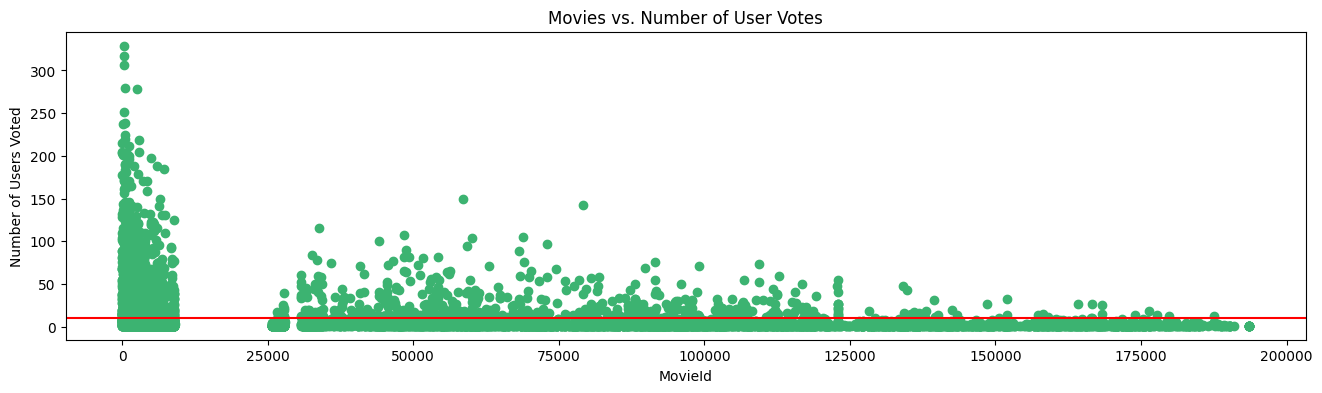

In [6]:
plt.figure(figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted, color='mediumseagreen')
plt.axhline(y=10, color='r') 
plt.xlabel('MovieId')
plt.ylabel('Number of Users Voted')
plt.title("Movies vs. Number of User Votes")
plt.show()

In [7]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

In [8]:
# Count number of ratings per user
no_movies_voted = ratings.groupby('userId')['rating'].agg('count')

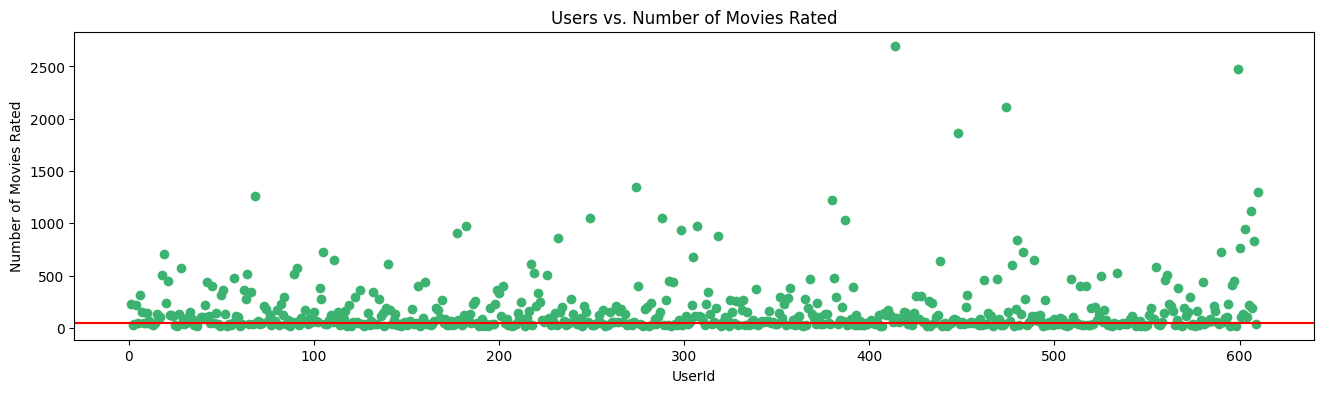

In [9]:
plt.figure(figsize=(16,4))
plt.scatter(no_movies_voted.index, no_movies_voted, color='mediumseagreen')
plt.axhline(y=50, color='r')  
plt.xlabel('UserId')
plt.ylabel('Number of Movies Rated')
plt.title("Users vs. Number of Movies Rated")
plt.show()

In [10]:
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]

In [11]:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

In [12]:
# Train KNN Model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)

,n_neighbors,20
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,-1


In [13]:
# Recommendation Function
def get_movie_recommendation(movie_name, n_movies_to_reccomend=10, plot=False):
    # Find movie by name
    movie_list = movies[movies['title'].str.contains(movie_name, case=False, regex=False)]
    
    if len(movie_list):
        # Get the first matched movieId
        movie_id = movie_list.iloc[0]['movieId']
        
        # Find index of the movie in final_dataset
        movie_idx = final_dataset[final_dataset['movieId'] == movie_id].index[0]
        
        # Find nearest neighbors
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n_movies_to_reccomend+1)
        
        # Sort neighbors exclude the first one which is the movie itself
        rec_movie_indices = sorted(
            list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
            key=lambda x: x[1]
        )[1:]
        
        # Build recommendation list
        recommend_frame = []
        for idx, dist in rec_movie_indices:
            movie_id = final_dataset.iloc[idx]['movieId']
            title = movies[movies['movieId'] == movie_id]['title'].values[0]
            recommend_frame.append({'Title': title, 'Distance': dist})
        
        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_reccomend+1))
        
        # Plot distances if requested
        if plot:
            plt.figure(figsize=(10,5))
            plt.barh(df['Title'], df['Distance'], color="teal")
            plt.xlabel("Cosine Distance (Lower = More Similar)")
            plt.title(f"Top {n_movies_to_reccomend} Recommendations for '{movie_name}'")
            plt.gca().invert_yaxis()  # tthe best is at the top
            plt.show()
        
        return df
    
    else:
        return "No movies found. Please check your input"

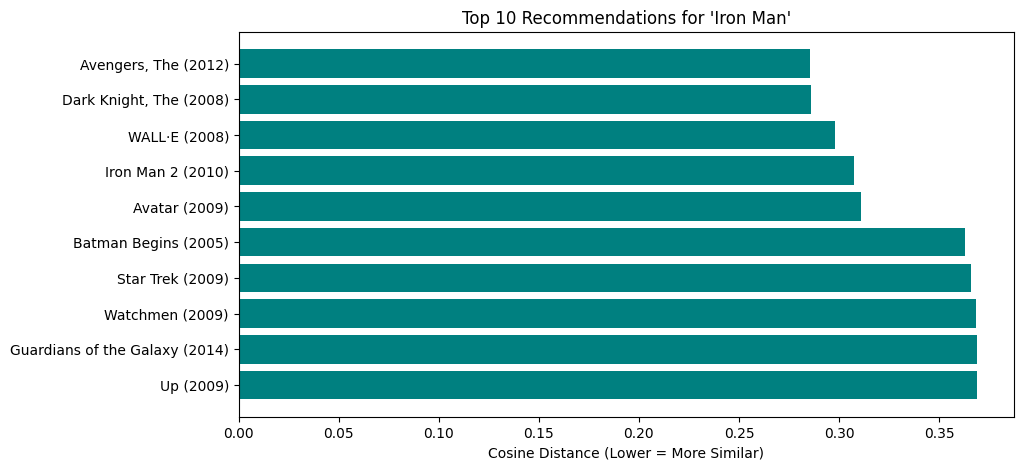

                             Title  Distance
1             Avengers, The (2012)  0.285319
2          Dark Knight, The (2008)  0.285835
3                    WALL·E (2008)  0.298138
4                Iron Man 2 (2010)  0.307492
5                    Avatar (2009)  0.310893
6             Batman Begins (2005)  0.362759
7                 Star Trek (2009)  0.366029
8                  Watchmen (2009)  0.368558
9   Guardians of the Galaxy (2014)  0.368758
10                       Up (2009)  0.368857


In [14]:
print(get_movie_recommendation("Iron Man", plot=True))

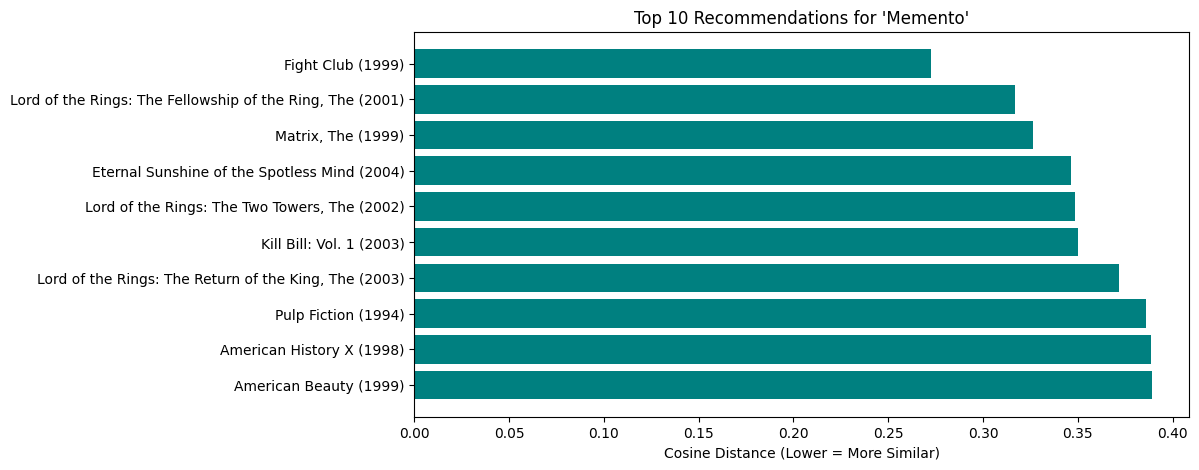

                                                Title  Distance
1                                   Fight Club (1999)  0.272380
2   Lord of the Rings: The Fellowship of the Ring,...  0.316777
3                                  Matrix, The (1999)  0.326215
4        Eternal Sunshine of the Spotless Mind (2004)  0.346196
5       Lord of the Rings: The Two Towers, The (2002)  0.348358
6                            Kill Bill: Vol. 1 (2003)  0.350167
7   Lord of the Rings: The Return of the King, The...  0.371622
8                                 Pulp Fiction (1994)  0.386235
9                           American History X (1998)  0.388615
10                             American Beauty (1999)  0.389346


In [15]:
print(get_movie_recommendation("Memento", plot=True))

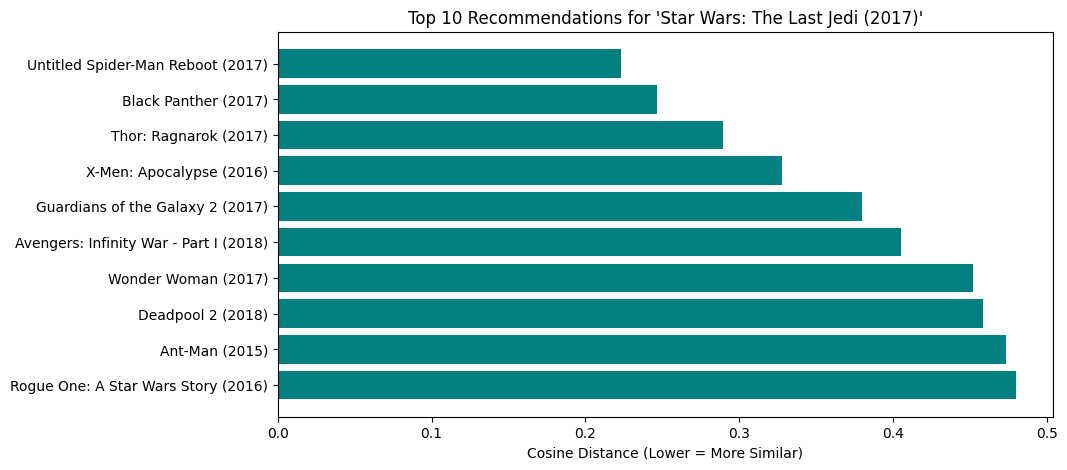

                                     Title  Distance
1        Untitled Spider-Man Reboot (2017)  0.223165
2                     Black Panther (2017)  0.246349
3                    Thor: Ragnarok (2017)  0.289740
4                 X-Men: Apocalypse (2016)  0.328109
5         Guardians of the Galaxy 2 (2017)  0.380205
6   Avengers: Infinity War - Part I (2018)  0.405511
7                      Wonder Woman (2017)  0.452184
8                        Deadpool 2 (2018)  0.458337
9                           Ant-Man (2015)  0.473843
10     Rogue One: A Star Wars Story (2016)  0.479944


In [16]:
print(get_movie_recommendation("Star Wars: The Last Jedi (2017)", plot=True))